In [1]:
import pandas as pd
import numpy as np
import os
import PIL
import PIL.Image
import glob, warnings
from sklearn.metrics import confusion_matrix, classification_report
from datasets import load_dataset
from transformers import ViTFeatureExtractor, AutoModelForImageClassification
from datasets import load_metric
from transformers import TrainingArguments
from transformers import Trainer

import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url


use_cuda = torch.cuda.is_available()
     

warnings.filterwarnings('ignore')


2022-12-27 10:55:35.982685: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
train = load_dataset('/local/data1/chash345/train')
valid = load_dataset('/local/data1/chash345/valid')
test = load_dataset('/local/data1/chash345/test')

Resolving data files:   0%|          | 0/2600 [00:00<?, ?it/s]

Using custom data configuration train-5ba040123c4f7080
Found cached dataset imagefolder (/home/chash345/.cache/huggingface/datasets/imagefolder/train-5ba040123c4f7080/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/870 [00:00<?, ?it/s]

Using custom data configuration valid-1603420759c35bdb
Found cached dataset imagefolder (/home/chash345/.cache/huggingface/datasets/imagefolder/valid-1603420759c35bdb/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/864 [00:00<?, ?it/s]

Using custom data configuration test-1f68a239285f9c45
Found cached dataset imagefolder (/home/chash345/.cache/huggingface/datasets/imagefolder/test-1f68a239285f9c45/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
np.count_nonzero(train['train']['label'])

2080

In [4]:
set(train['train']['label'])

{0, 1}

In [5]:
train['train'][2555]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2990x2990>,
 'label': 1}

In [6]:
model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

In [7]:
example_feature = feature_extractor(
    train['train'][100]['image'],
    return_tensors = 'pt'
)

In [8]:
example_feature

{'pixel_values': tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]])}

In [9]:
example_feature['pixel_values'].shape

torch.Size([1, 3, 224, 224])

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [11]:
def preprocess(batch):
    inputs = feature_extractor(
        batch['image'],
        return_tensors = 'pt'
    ).to(device)

    inputs['label'] = batch['label']

    return inputs

In [12]:
prepared_train = train['train'].with_transform(preprocess)
prepared_valid = valid['train'].with_transform(preprocess)
prepared_test = test['train'].with_transform(preprocess)

Parameter 'transform'=<function preprocess at 0x7fd5cc713040> of the transform datasets.arrow_dataset.Dataset.set_format couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [13]:
prepared_test.format

{'type': 'custom',
 'format_kwargs': {'transform': <function __main__.preprocess(batch)>},
 'columns': ['image', 'label'],
 'output_all_columns': False}

In [14]:
prepared_test.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['aff', 'control'], id=None)}

In [15]:
prepared_test.set_format(type=prepared_test.format["type"], columns=list(prepared_test.features.keys()), transform= preprocess)

In [16]:
prepared_test.format

{'type': 'custom',
 'format_kwargs': {'transform': <function __main__.preprocess(batch)>},
 'columns': ['image', 'label'],
 'output_all_columns': False}

In [17]:
def collate_fn(batch):
    return{
        'pixel_values':torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [18]:
metric = load_metric('accuracy')

def compute_metrics(p):
    return metric.compute(
        predictions = np.argmax(p.predictions, axis=1),
        references = p.label_ids
    )

In [19]:
training_args = TrainingArguments(
    output_dir= '/local/data1/chash345/Vision-Transformer-Research-Project/vit16_w_o_augment',
    seed=42,
    per_device_train_batch_size=16,
    evaluation_strategy='steps',
    num_train_epochs=10,
    save_steps=200,
    eval_steps=200,
    logging_steps=10,
    learning_rate=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True,

)

In [20]:
from transformers import ViTForImageClassification

labels = train['train']['label']

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels = len(labels)
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:


trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_valid,
    tokenizer=feature_extractor
)

In [ ]:
model_results = trainer.train()

trainer.save_model()
trainer.log_metrics('train', model_results.metrics)
trainer.save_metrics('train', model_results.metrics)

trainer.save_state()

In [34]:
model = ViTForImageClassification.from_pretrained('/local/data1/chash345/vit16_w_o_augment_model/checkpoint-2000', num_labels=2, ignore_mismatched_sizes=True )
    

training_args = TrainingArguments(
    output_dir= '/local/data1/chash345/vit16_w_o_augment_model/checkpoint-2000',
    #seed=42,
    per_device_train_batch_size=1,
    num_train_epochs=1,
    evaluation_strategy='steps',
    save_strategy='steps',
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True,
    do_predict=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)
#trainer = Trainer(model=model)
#trainer.model = model.cuda()
prediction_test = trainer.predict(prepared_test)

loading configuration file /local/data1/chash345/vit16_w_o_augment_model/checkpoint-2000/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "problem_type": "single_label_classification",
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.24.0"
}

loading weights file /local/data1/chash345/vit16_w_o_augment_model/checkpoint-2000/pytorch_model.bin
All model checkpoint weights were used when initializing ViTForImageClassification.

Some weights of ViTForImageClassification were not initialized from the mo

In [35]:
prediction_test

PredictionOutput(predictions=array([[ 3.0179596e-01, -6.1344177e-02],
       [ 1.0100801e-01,  2.9964931e-04],
       [ 3.1750557e-01, -6.5698713e-02],
       ...,
       [ 1.0588872e-01, -7.0232674e-03],
       [ 8.4336765e-02, -2.4466271e-02],
       [ 6.5266371e-02, -1.9048737e-02]], dtype=float32), label_ids=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1

In [36]:
import tensorflow as tf
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

In [37]:
prediction = tf.round(tf.nn.sigmoid(prediction_test.predictions))

In [38]:
prediction
prediction_test = np.argmax(prediction, 1)

In [39]:
y_true = test['train']['label']
y_pred = prediction_test

In [40]:
confusion_matrix(y_true= y_true , y_pred=y_pred)

array([[173,   0],
       [691,   0]])

In [41]:
pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).T

,precision,recall,f1-score,support
0,0.200231,1.000000,0.333655,173.000000
1,0.000000,0.000000,0.000000,691.000000
accuracy,0.200231,0.200231,0.200231,0.200231
macro avg,0.100116,0.500000,0.166827,864.000000
weighted avg,0.040093,0.200231,0.066808,864.000000


In [42]:
# %%
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc

# %%
fpr, tpr, thresholds = roc_curve(y_true, prediction_test )

In [43]:
# %%
roc_auc_score(y_true , prediction_test )

0.5

In [44]:
roc_auc = auc(fpr, tpr)

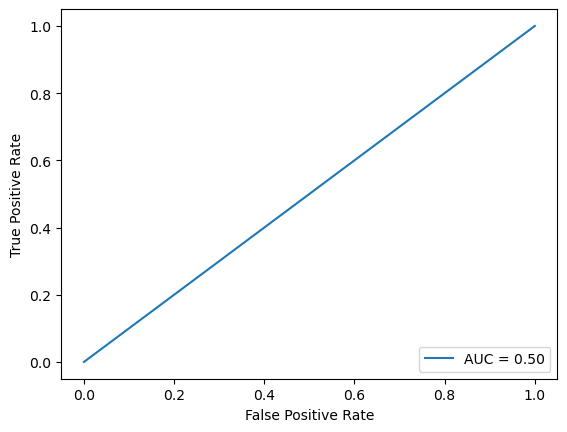

In [45]:
import matplotlib.pyplot as plt
display = RocCurveDisplay(fpr=fpr,tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()

### We see that Vision Transformer beats all other CNN models and gets the accuracy of around 90% on test set and AUROC of 0.81, considering a highly imabalanced dataset